In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('../data_raw/ventas.csv')
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado
0,919,31/01/2024,10,25,5,1,Completa
1,947,31/01/2024,106,5,1,4,Completa
2,1317,31/1/2024,235,25,3,3,Completa
3,1607,31/1/2024,114,15,5,1,Completa
4,2038,31/1/2024,132,2,5,4,Completa


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID_Venta     3029 non-null   int64 
 1   Fecha        3029 non-null   object
 2   ID_Cliente   3029 non-null   int64 
 3   ID_Producto  3029 non-null   int64 
 4   Cantidad     3029 non-null   int64 
 5   Método_Pago  3029 non-null   int64 
 6   Estado       3029 non-null   object
dtypes: int64(5), object(2)
memory usage: 165.8+ KB


In [4]:
df.describe()

,ID_Venta,ID_Cliente,ID_Producto,Cantidad,Método_Pago
count,3029.000000,3029.000000,3029.000000,3029.000000,3029.000000
mean,1492.663585,162.208320,19.675801,3.475404,3.359194
std,865.690540,94.276683,10.989542,1.702960,1.425749
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,729.000000,79.000000,10.000000,2.000000,2.000000
50%,1486.000000,162.000000,20.000000,3.000000,4.000000
75%,2243.000000,243.000000,29.000000,5.000000,5.000000
max,3000.000000,326.000000,38.000000,6.000000,5.000000


In [5]:
# Parece que algunas IDs están duplicadas (min 1, max 3000, count 3029)
print(df['ID_Venta'].value_counts().head())

# Eliminamos duplicados en 'ID_Venta'
df = df.drop_duplicates(subset='ID_Venta')

ID_Venta
670    2
683    2
680    2
672    2
675    2
Name: count, dtype: int64


In [6]:
categorias = pd.read_csv('../data_raw/categorias.csv')
productos = pd.read_csv('../data_raw/productos.csv')
clientes = pd.read_csv('../data_raw/clientes.csv')
metodos_pago = pd.read_csv('../data_raw/metodos_pago.csv')

# Agregar a df la categoria de product desde productos
df = df.merge(productos[['ID_Producto', 'Categoría']], on='ID_Producto', how='left')

# Agregamos ID_Categoria desde categorias
df = df.merge(categorias[['Categoría', 'ID_Categoria']], on='Categoría', how='left')

# Agregamos Precio_Unitario desde productos
df = df.merge(productos[['ID_Producto', 'Precio_Unitario']], on='ID_Producto', how='left')

# Agregamos Región desde clientes por ID_Cliente
df = df.merge(clientes[['ID_Cliente', 'Región']], on='ID_Cliente', how='left')

# Agregamos Metodo_Pago desde metodos_pago por ID_Metodo
# En df, hay una columna Método_pago que es el ID del método de pago
# En metodos_pago, hay una columna Método que es el nombre del método de pago y ID_Metodo que es el ID del método de pago
df = df.merge(metodos_pago[['ID_Metodo', 'Método']], left_on='Método_Pago', right_on='ID_Metodo', how='left')

df = df.rename(columns={'Categoría': 'Categoria', 'Región': 'Region', 'Método_Pago': 'Metodo_Pago_cat', 'Método': 'Metodo_Pago'})

df.set_index('ID_Venta', inplace=True)
df = df.sort_index()

df.head()

,Fecha,ID_Cliente,ID_Producto,Cantidad,Metodo_Pago_cat,Estado,Categoria,ID_Categoria,Precio_Unitario,Region,ID_Metodo,Metodo_Pago
ID_Venta,,,,,,,,,,,,
1,28/08/2024,298,17,1,3,Completa,Frutas y Verduras,4,"6,54",Buenos Aires,3,Tarjeta de Débito
2,01/06/2024,37,15,3,1,Completa,Panadería,3,"3,51",Cuyo,1,Efectivo
3,29/02/2024,31,21,3,3,Completa,Frutas y Verduras,4,"3,25",Centro,3,Tarjeta de Débito
4,26/09/2024,111,37,5,4,Completa,Conservas,8,"3,65",Cuyo,4,Mercado Pago
5,06/09/2024,188,4,4,4,Completa,Lácteos,1,"19,23",Cuyo,4,Mercado Pago


In [7]:
# Limpieza de datos
# Precio_Unitario esta como x,xx en vez de x.xx
df['Precio_Unitario'] = df['Precio_Unitario'].str.replace(',', '.').astype(float)
df.head()

,Fecha,ID_Cliente,ID_Producto,Cantidad,Metodo_Pago_cat,Estado,Categoria,ID_Categoria,Precio_Unitario,Region,ID_Metodo,Metodo_Pago
ID_Venta,,,,,,,,,,,,
1,28/08/2024,298,17,1,3,Completa,Frutas y Verduras,4,6.54,Buenos Aires,3,Tarjeta de Débito
2,01/06/2024,37,15,3,1,Completa,Panadería,3,3.51,Cuyo,1,Efectivo
3,29/02/2024,31,21,3,3,Completa,Frutas y Verduras,4,3.25,Centro,3,Tarjeta de Débito
4,26/09/2024,111,37,5,4,Completa,Conservas,8,3.65,Cuyo,4,Mercado Pago
5,06/09/2024,188,4,4,4,Completa,Lácteos,1,19.23,Cuyo,4,Mercado Pago


In [8]:
# Podemos observar que enero empieza en el 31, por lo que eliminamos ese mes
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')
print(df.sort_values('Fecha').head())

df = df[df['Fecha'].dt.month != 1]


              Fecha  ID_Cliente  ID_Producto  Cantidad  Metodo_Pago_cat  \
ID_Venta                                                                  
947      2024-01-31         106            5         1                4   
2578     2024-01-31         201           31         6                3   
2038     2024-01-31         132            2         5                4   
919      2024-01-31          10           25         5                1   
1317     2024-01-31         235           25         3                3   

            Estado            Categoria  ID_Categoria  Precio_Unitario  \
ID_Venta                                                                 
947       Completa              Lácteos             1             5.65   
2578      Completa  Galletitas y Snacks             7             5.24   
2038      Completa              Lácteos             1             5.21   
919       Completa           Congelados             5            15.45   
1317      Completa           C

In [9]:
# Creamos tickets (mismo cliente en misma fecha)
df['ID_Ticket'] = df.groupby(['ID_Cliente', 'Fecha']).ngroup()
df.sort_values('ID_Ticket').head()
tickets_multiproducto = len(df) - df['ID_Ticket'].nunique()

print(f'Tickets con multiples productos: {tickets_multiproducto}')

# Imprimimos algunos tickets con multiples productos

# Agrupamos por ID_Ticket y contamos productos
ticket_product_counts = df.groupby('ID_Ticket')['ID_Producto'].count()

multi_product_tickets = df[df.duplicated(subset=['ID_Ticket'], keep=False)]
print(multi_product_tickets.sort_values('ID_Ticket').head(5))

Tickets con multiples productos: 44
              Fecha  ID_Cliente  ID_Producto  Cantidad  Metodo_Pago_cat  \
ID_Venta                                                                  
798      2024-07-09          10           24         5                4   
1103     2024-07-09          10           34         6                5   
1032     2024-11-10          20            8         2                5   
709      2024-11-10          20           13         2                3   
687      2024-11-09          43           30         2                1   

            Estado            Categoria  ID_Categoria  Precio_Unitario  \
ID_Venta                                                                 
798       Completa           Congelados             5            13.54   
1103      Completa  Galletitas y Snacks             7             5.45   
1032      Completa           Carnicería             2            16.21   
709       Completa            Panadería             3            12.

Notamos que solo hay 44 (de 3000) tickets con mas de un producto. Esto tiene implicaciones en el analisis de valor promedio del ticket y debe ser analizado con el equipo que recolectó los datos.

## EDA

In [10]:
# Cuanto se vende por categoria

df['Monto_Venta'] = df['Cantidad'] * df['Precio_Unitario']
ventas_por_categoria = df.groupby('Categoria')['Monto_Venta'].sum().reset_index()

df['Monto_Venta'].describe()

count    2993.000000
mean       34.362583
std        27.494472
min         3.250000
25%        14.500000
50%        26.160000
75%        46.350000
max       171.360000
Name: Monto_Venta, dtype: float64

Numero de outliers en Monto de Venta: 101
Porcentaje de outliers en Monto de Venta: 3.37%
              Fecha  Monto_Venta
ID_Venta                        
1565     2024-02-01       171.36
271      2024-02-28       171.36
2291     2024-03-12       171.36
1552     2024-04-29       171.36
2728     2024-05-13       171.36
2477     2024-06-24       171.36
776      2024-07-13       171.36
2282     2024-07-27       171.36
1522     2024-08-02       171.36
1101     2024-08-09       171.36


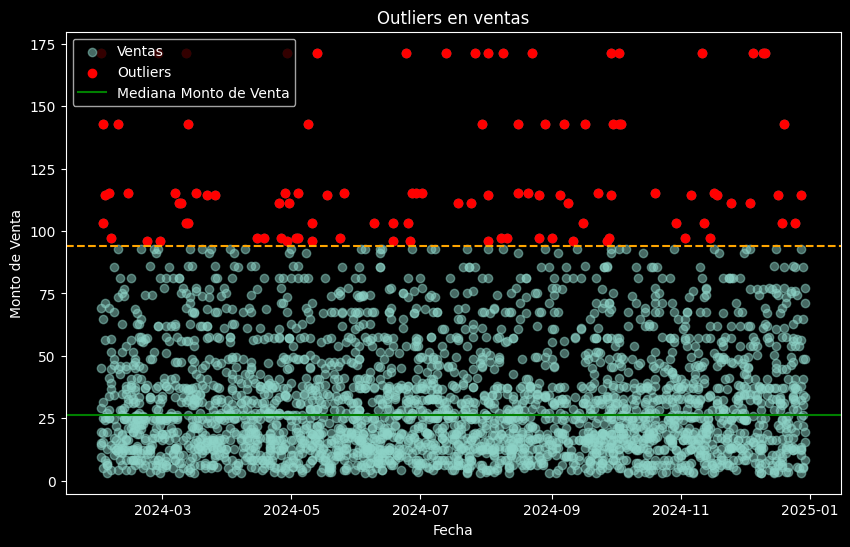

In [11]:
# Eliminamos Outliers
Q1 = df['Monto_Venta'].quantile(0.25)
Q3 = df['Monto_Venta'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Monto_Venta'] < (Q1 - 1.5 * IQR)) | (df['Monto_Venta'] > (Q3 + 1.5 * IQR))]

print(f"Numero de outliers en Monto de Venta: {len(outliers)}")
print(f"Porcentaje de outliers en Monto de Venta: {len(outliers) / len(df) * 100:.2f}%")
print(outliers[['Fecha', 'Monto_Venta']].sort_values(by=['Monto_Venta', 'Fecha'], ascending=[False, True]).head(10))

# Plot days vs months with outliers highlighted
plt.figure(figsize=(10, 6))
plt.scatter(df['Fecha'], df['Monto_Venta'], label='Ventas', alpha=0.5)
plt.scatter(outliers['Fecha'], outliers['Monto_Venta'], color='red', label='Outliers')
# IQR

plt.axhline(Q3 + 1.5 * IQR, color='orange', linestyle='--')
plt.axhline(df['Monto_Venta'].median(), color='green', linestyle='-', label='Mediana Monto de Venta')

plt.xlabel('Fecha')
plt.ylabel('Monto de Venta')
plt.title('Outliers en ventas')
plt.legend()
plt.show()



In [12]:
# Eliminamos outliers del dataframe original
df.drop(df[df['Categoria'].isin(outliers['Categoria'])].index, inplace=True)

# Guardamos el dataframe limpio
df.to_csv('../data_clean/ventas_clean.csv')

Podemos observar que los outliers de precio no corresponden a días especiales en Argentina o globalmente, por lo que asumimos que son aleatorios y decidimos eliminarlos para que no afecten el analisis. Es extraño que todos tienen el mismo monto, por lo que es posible que sean errores en la recolección de datos. De no ser errores, notamos para fines de negocio, que alrededor de 2-3 veces al mes hay una compra alta que en una primera aproximación es irregular e impredecible.

/tmp/ipykernel_54256/590398086.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_54256/590398086.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


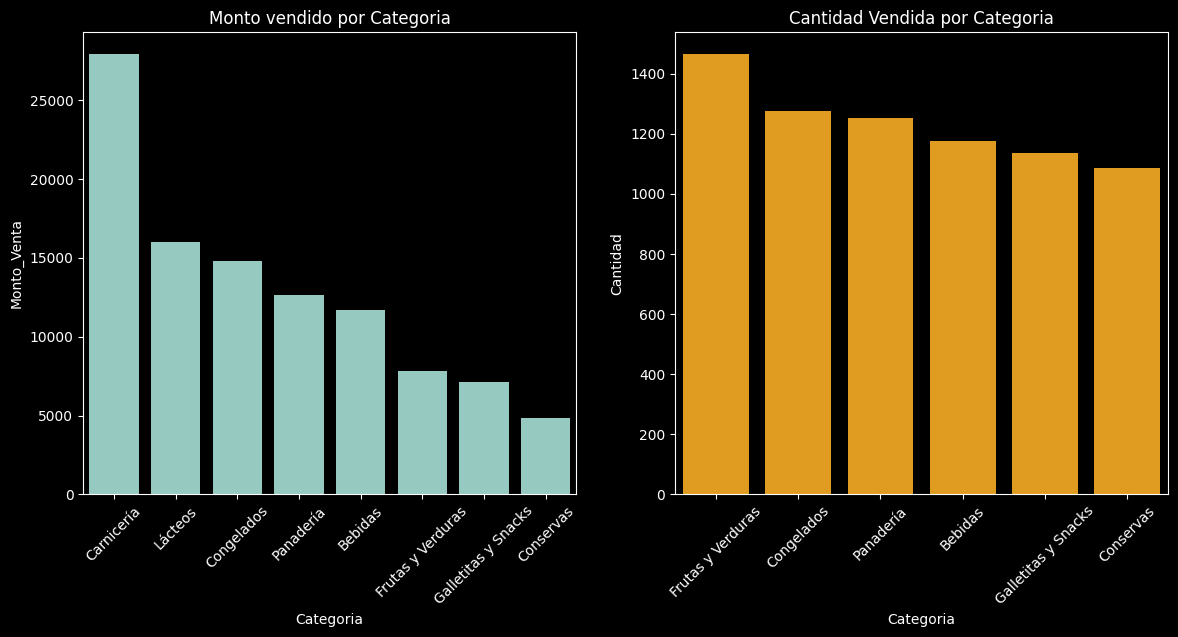

In [13]:
# Plot
cantidad_por_categoria = df.groupby('Categoria')['Cantidad'].sum().reset_index()
ventas_por_categoria = ventas_por_categoria.sort_values(by='Monto_Venta', ascending=False)
cantidad_por_categoria = cantidad_por_categoria.sort_values(by='Cantidad', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=ventas_por_categoria, x='Categoria', y='Monto_Venta', ax=ax[0])
ax[0].set_title('Monto vendido por Categoria')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
sns.barplot(data=cantidad_por_categoria, x='Categoria', y='Cantidad', ax=ax[1], color='orange')
ax[1].set_title('Cantidad Vendida por Categoria')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
plt.show()


Podemos observar que Carnicería es la categoría con mayores ventas en Monto. Sin embargo, en Cantidad, Frutas y Verduras lidera. Esto indica que los productos de Carnicería tienen un precio promedio más alto en comparación con Frutas y Verduras. Estos datos pueden ser útiles para proyecciones financieras y de inventario.

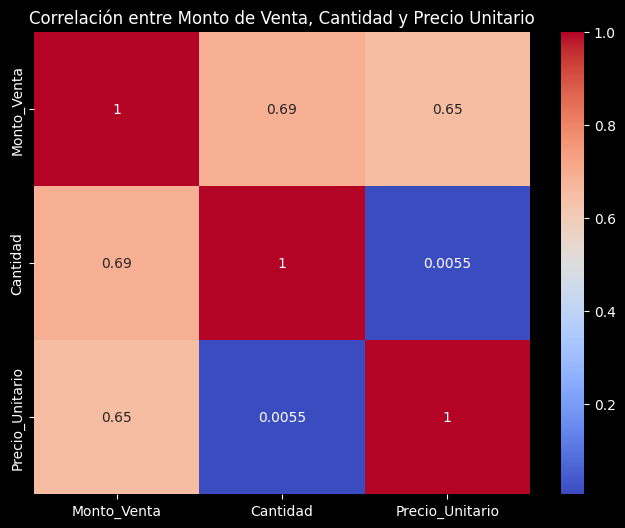

In [14]:
# Correlacion entre Monto  de Venta, Cantidad, y Precio Unitario
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Monto_Venta', 'Cantidad', 'Precio_Unitario']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre Monto de Venta, Cantidad y Precio Unitario')
plt.show()

Podemos ver que el precio unitario afecta el monto de venta un poco más que la cantidad vendida (0.71 vs 0.62). Además, un precio mayor no hace que los clientes compren menos cantidad (correlación positiva de 0.01).

         Region  Cantidad  Clientes  Cantidad_por_Cliente
3          Cuyo      1110        44             25.227273
4           NEA       882        37             23.837838
5           NOA       165         7             23.571429
0  Buenos Aires      2488       111             22.414414
2        Centro      1364        63             21.650794
1     Patagonia      1382        64             21.593750


/tmp/ipykernel_54256/602509258.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(cantidad_sobre_clientes['Region'], rotation=45)


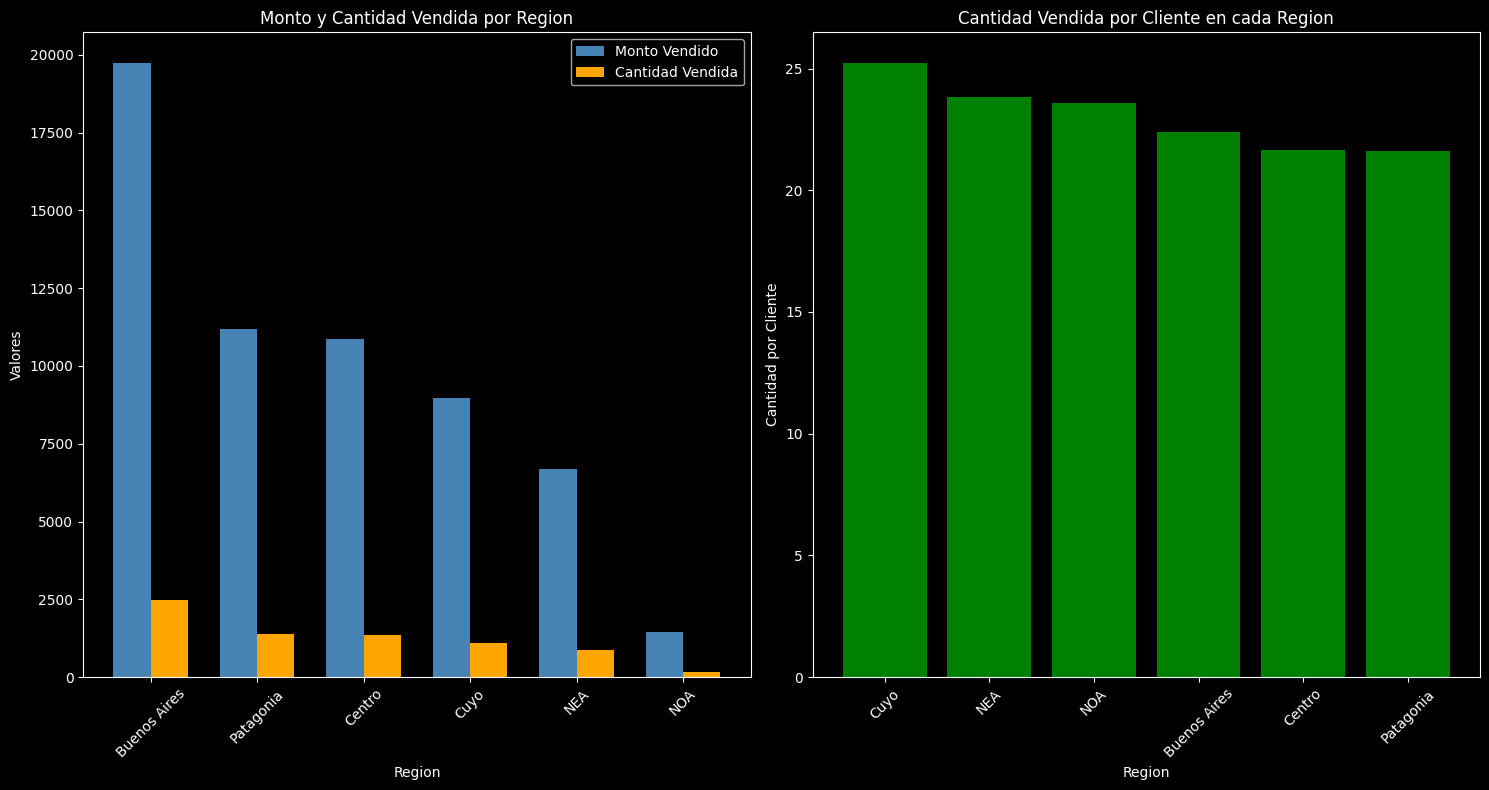

In [15]:
# Cantidad vendida por region
ventas_por_region = df.groupby('Region')['Monto_Venta'].sum().reset_index()
cantidad_por_region = df.groupby('Region')['Cantidad'].sum().reset_index()

# Sort
ventas_por_region = ventas_por_region.sort_values(by='Monto_Venta', ascending=False)
cantidad_por_region = cantidad_por_region.sort_values(by='Cantidad', ascending=False)


# Cantidad vendida por region / clientes en cada region
clientes_por_region = df[['ID_Cliente', 'Region']].groupby('Region')['ID_Cliente'].nunique().reset_index(name='Clientes')

cantidad_sobre_clientes = cantidad_por_region.merge(clientes_por_region, on='Region')
cantidad_sobre_clientes['Cantidad_por_Cliente'] = cantidad_sobre_clientes['Cantidad'] / cantidad_sobre_clientes['Clientes']

# Sort
cantidad_sobre_clientes = cantidad_sobre_clientes.sort_values(by='Cantidad_por_Cliente', ascending=False)

print(cantidad_sobre_clientes)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
x = np.arange(len(ventas_por_region))
width = 0.35

ax[0].bar(x - width/2, ventas_por_region['Monto_Venta'], width, label='Monto Vendido', color='steelblue')
ax[0].bar(x + width/2, cantidad_por_region['Cantidad'], width, label='Cantidad Vendida', color='orange')

ax[0].set_xlabel('Region')
ax[0].set_ylabel('Valores')
ax[0].set_title('Monto y Cantidad Vendida por Region')
ax[0].set_xticks(x)
ax[0].set_xticklabels(ventas_por_region['Region'], rotation=45)
ax[0].legend()

ax[1].bar(cantidad_sobre_clientes['Region'], cantidad_sobre_clientes['Cantidad_por_Cliente'], color='green')
ax[1].set_xlabel('Region')
ax[1].set_ylabel('Cantidad por Cliente')
ax[1].set_title('Cantidad Vendida por Cliente en cada Region')
ax[1].set_xticklabels(cantidad_sobre_clientes['Region'], rotation=45)

plt.tight_layout()
plt.show()

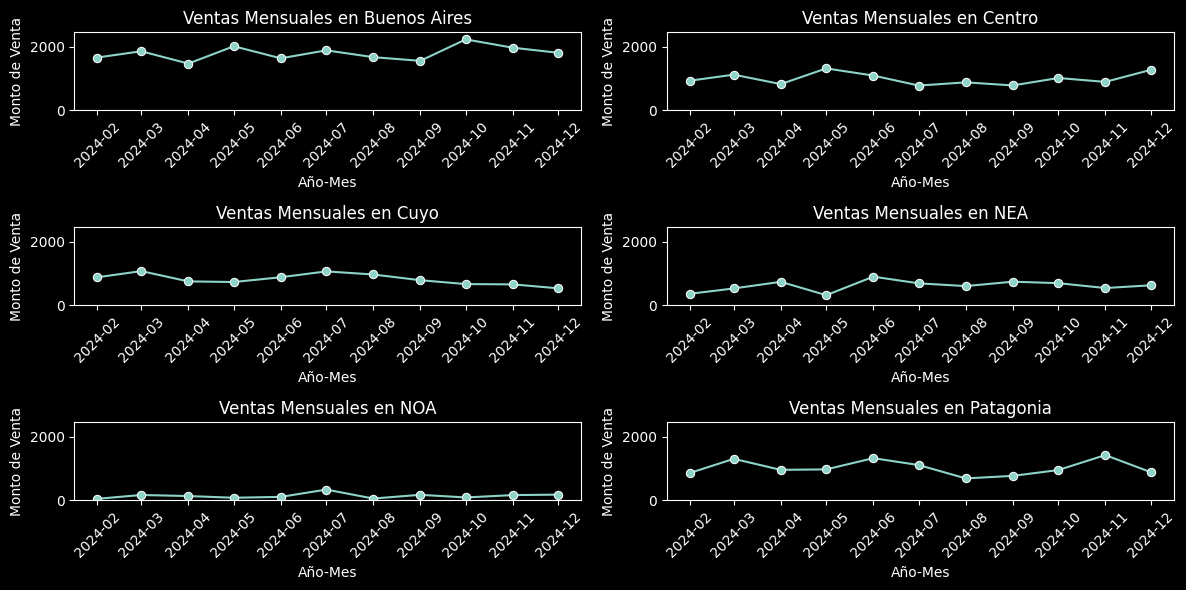

In [16]:
# Ventas mensuales por region
ventas_mensuales_region = df.copy()
ventas_mensuales_region['YearMonth'] = ventas_mensuales_region['Fecha'].dt.to_period('M')
ventas_mensuales_region = ventas_mensuales_region.groupby(['YearMonth', 'Region'])['Monto_Venta'].sum().reset_index()
ventas_mensuales_region['YearMonth'] = ventas_mensuales_region['YearMonth'].dt.to_timestamp()
fig, ax = plt.subplots(3, 2, figsize=(12, 6))
regions = ventas_mensuales_region['Region'].unique()
for i, region in enumerate(regions):
    row = i // 2
    col = i % 2
    region_data = ventas_mensuales_region[ventas_mensuales_region['Region'] == region]
    sns.lineplot(data=region_data, x='YearMonth', y='Monto_Venta', ax=ax[row, col], marker='o')
    ax[row, col].set_title(f'Ventas Mensuales en {region}')
    ax[row, col].set_xlabel('Año-Mes')
    ax[row, col].set_ylabel('Monto de Venta')
    ax[row, col].tick_params(axis='x', rotation=45)
    ax[row, col].set_ylim(0, ventas_mensuales_region['Monto_Venta'].max() * 1.1)
plt.tight_layout()
plt.show()

Podemos ver que Buenos Aires es la región con mayores ventas tanto en monto como en cantidad (son proporcionales, pues a diferencia de las ventas por categoria, los precios por cada región son constantes), mientras que NOA es la región con menores ventas. Sin embargo, esto se debe a las diferencias de población y tamaño de mercado entre regiones.

Notamos que los clientes de Patagonia son los que menos gastan en promedio (29.7), mientras que en Cuyo gastan más (33.3). Esto representa una diferencia de alrededor de 10% 

/tmp/ipykernel_54256/1414287781.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ventas_por_mes['Fecha'] = pd.Categorical(ventas_por_mes['Fecha'], categories=pd.date_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='M').strftime('%B %Y'), ordered=True)
/tmp/ipykernel_54256/1414287781.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)


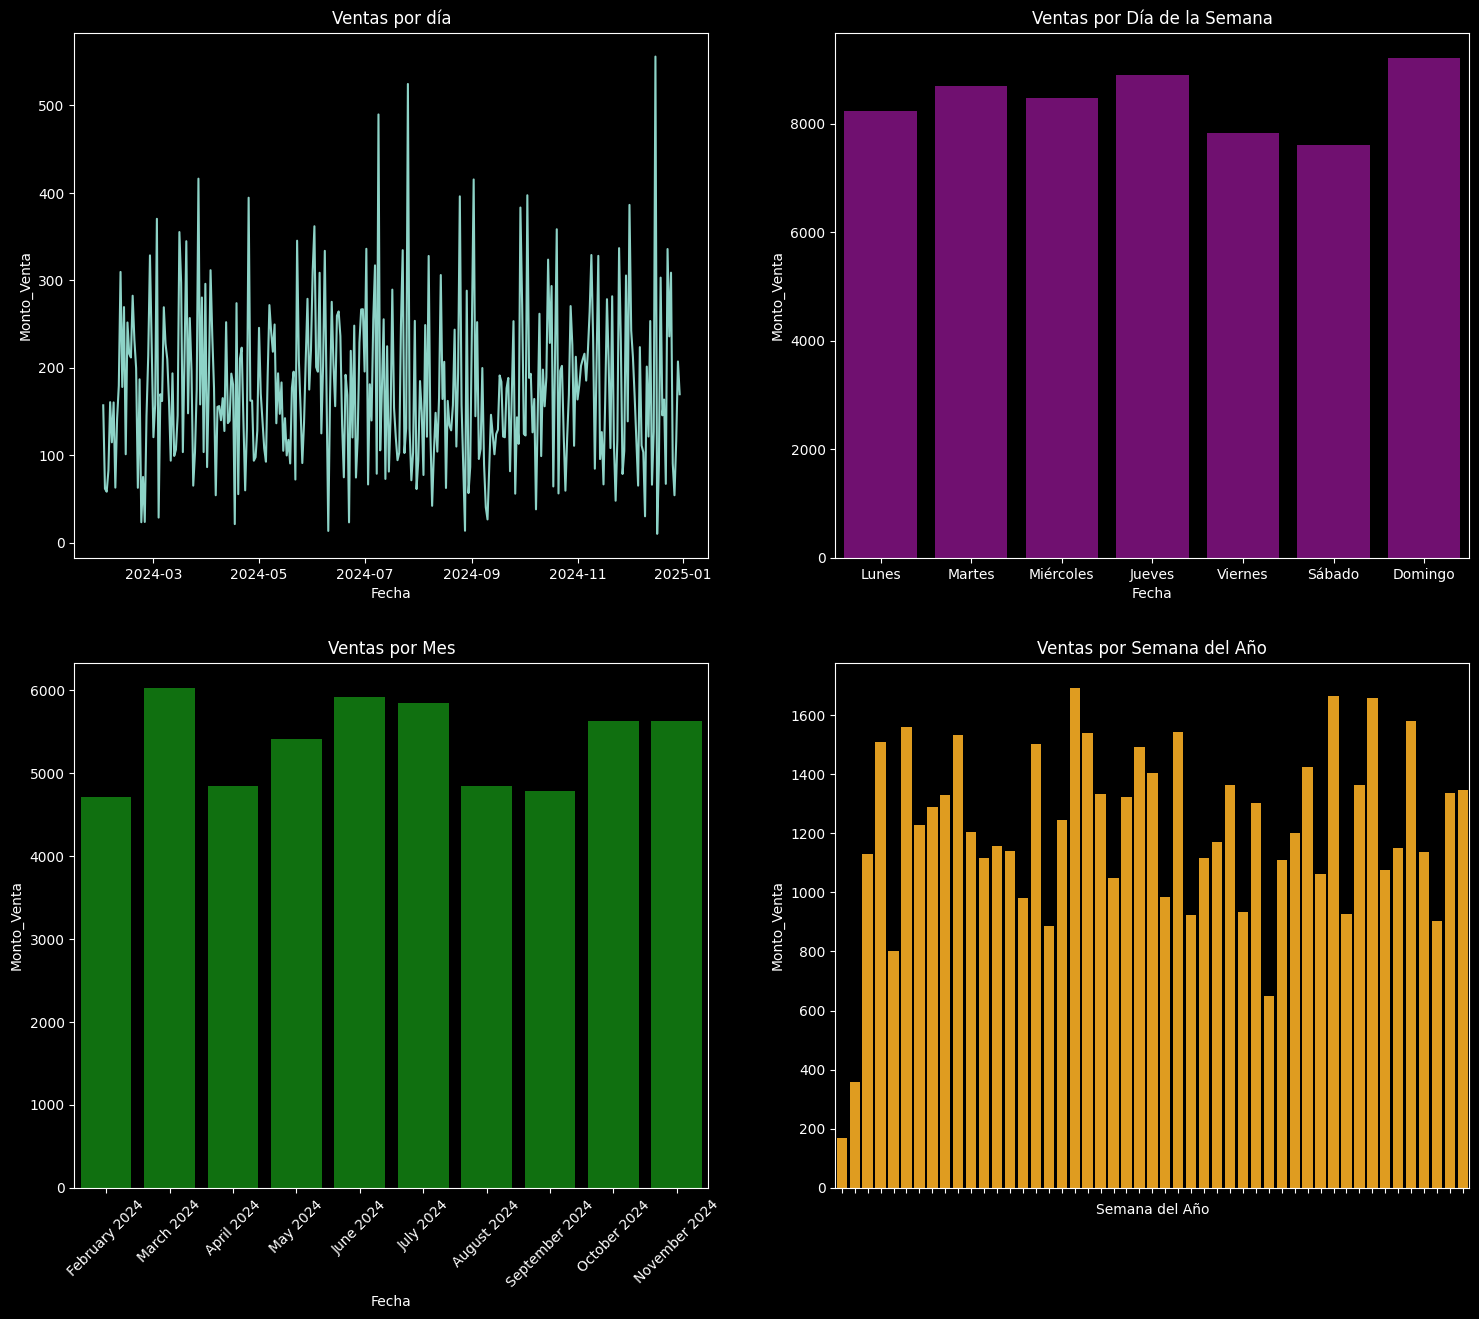

In [17]:
# Ventas a través del tiempo
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
ventas_por_fecha = df.groupby('Fecha')['Monto_Venta'].sum().reset_index()

# Ventas por mes
ventas_por_mes = df.groupby(df['Fecha'].dt.to_period('M'))['Monto_Venta'].sum().reset_index()

# Renombramos a meses
ventas_por_mes['Fecha'] = ventas_por_mes['Fecha'].dt.strftime('%B %Y')
ventas_por_mes['Fecha'] = pd.Categorical(ventas_por_mes['Fecha'], categories=pd.date_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='M').strftime('%B %Y'), ordered=True)
ventas_por_mes = ventas_por_mes.sort_values('Fecha')

# Ventas por dia de la semana
ventas_por_dia = df.groupby(df["Fecha"].dt.day_name())['Monto_Venta'].sum().reset_index()

# Renombramos a dias en español y ordenamos
ventas_por_dia['Fecha'] = ventas_por_dia['Fecha'].map({'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'})
ventas_por_dia.sort_values(by='Fecha', key=lambda x: x.map({'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3, 'Viernes': 4, 'Sábado': 5, 'Domingo': 6}), inplace=True)

ventas_por_semana = df.groupby(df['Fecha'].dt.isocalendar().week)['Monto_Venta'].sum().reset_index()

fig, ax = plt.subplots(2, 2, figsize=(18, 15))
ax = ax.flatten()

# Ventas por dia
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='Monto_Venta', ax=ax[0])
ax[0].set_title('Ventas por día')

# Ventas por dia de la semana
sns.barplot(data=ventas_por_dia, x='Fecha', y='Monto_Venta', ax=ax[1], color='purple')
ax[1].set_title('Ventas por Día de la Semana')


# Ventas por mes
sns.barplot(data=ventas_por_mes, x='Fecha', y='Monto_Venta', ax=ax[2], color='green')
ax[2].set_title('Ventas por Mes')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)

# ventas por semana
sns.barplot(data=ventas_por_semana, x='week', y='Monto_Venta', ax=ax[3], color='orange')
ax[3].set_title('Ventas por Semana del Año')
ax[3].set_xlabel('Semana del Año')
ax[3].set_xticklabels([])

plt.show() 

/tmp/ipykernel_54256/89295235.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_54256/89295235.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


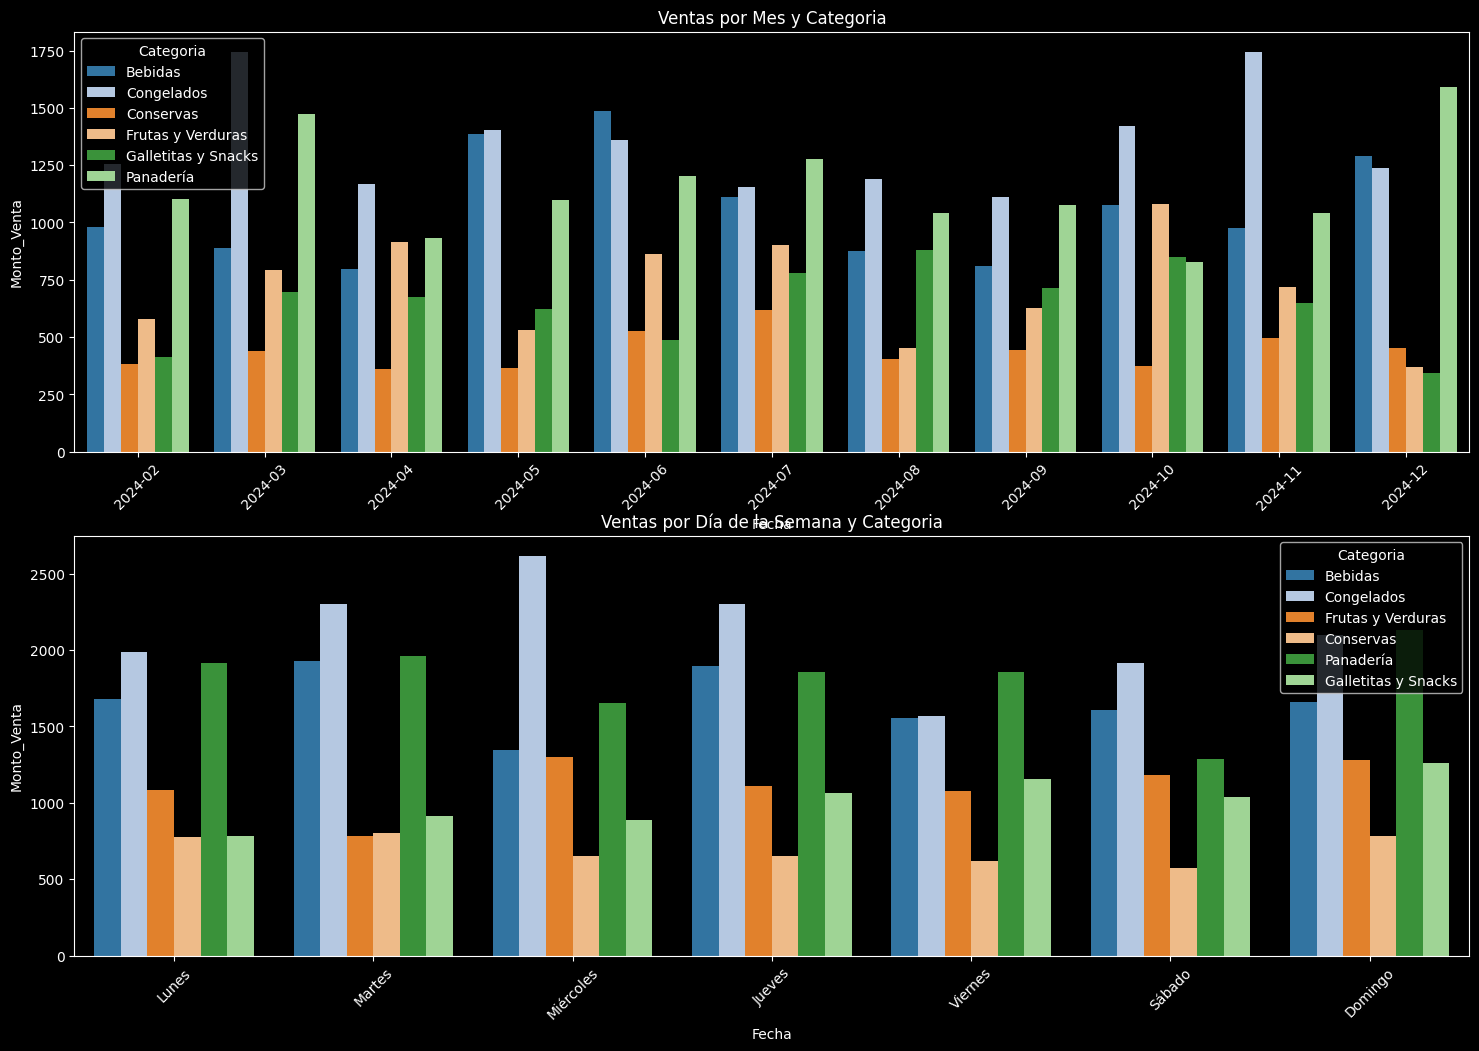

In [18]:
# Ventas por mes y dia por categoría
ventas_por_mes_categoria = df.groupby([df['Fecha'].dt.to_period('M'), 'Categoria'])['Monto_Venta'].sum().reset_index()
ventas_por_dia_categoria = df.groupby([df['Fecha'].dt.day_name(), 'Categoria'])['Monto_Venta'].sum().reset_index()

fig, ax = plt.subplots(2, 1, figsize=(18, 12))
sns.barplot(data=ventas_por_mes_categoria, x='Fecha', y='Monto_Venta', hue='Categoria', ax=ax[0], palette='tab20')
ax[0].set_title('Ventas por Mes y Categoria')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

# Ordenamos dias
ventas_por_dia_categoria['Fecha'] = ventas_por_dia_categoria['Fecha'].map({'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'})
ventas_por_dia_categoria = ventas_por_dia_categoria.sort_values(by='Fecha', key=lambda x: x.map({'Lunes': 0, 'Martes': 1, 'Miércoles': 2, 'Jueves': 3, 'Viernes': 4, 'Sábado': 5, 'Domingo': 6}))

sns.barplot(data=ventas_por_dia_categoria, x='Fecha', y='Monto_Venta', hue='Categoria', ax=ax[1], palette='tab20')
ax[1].set_title('Ventas por Día de la Semana y Categoria')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
plt.show()

/tmp/ipykernel_54256/4281344169.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_categories)


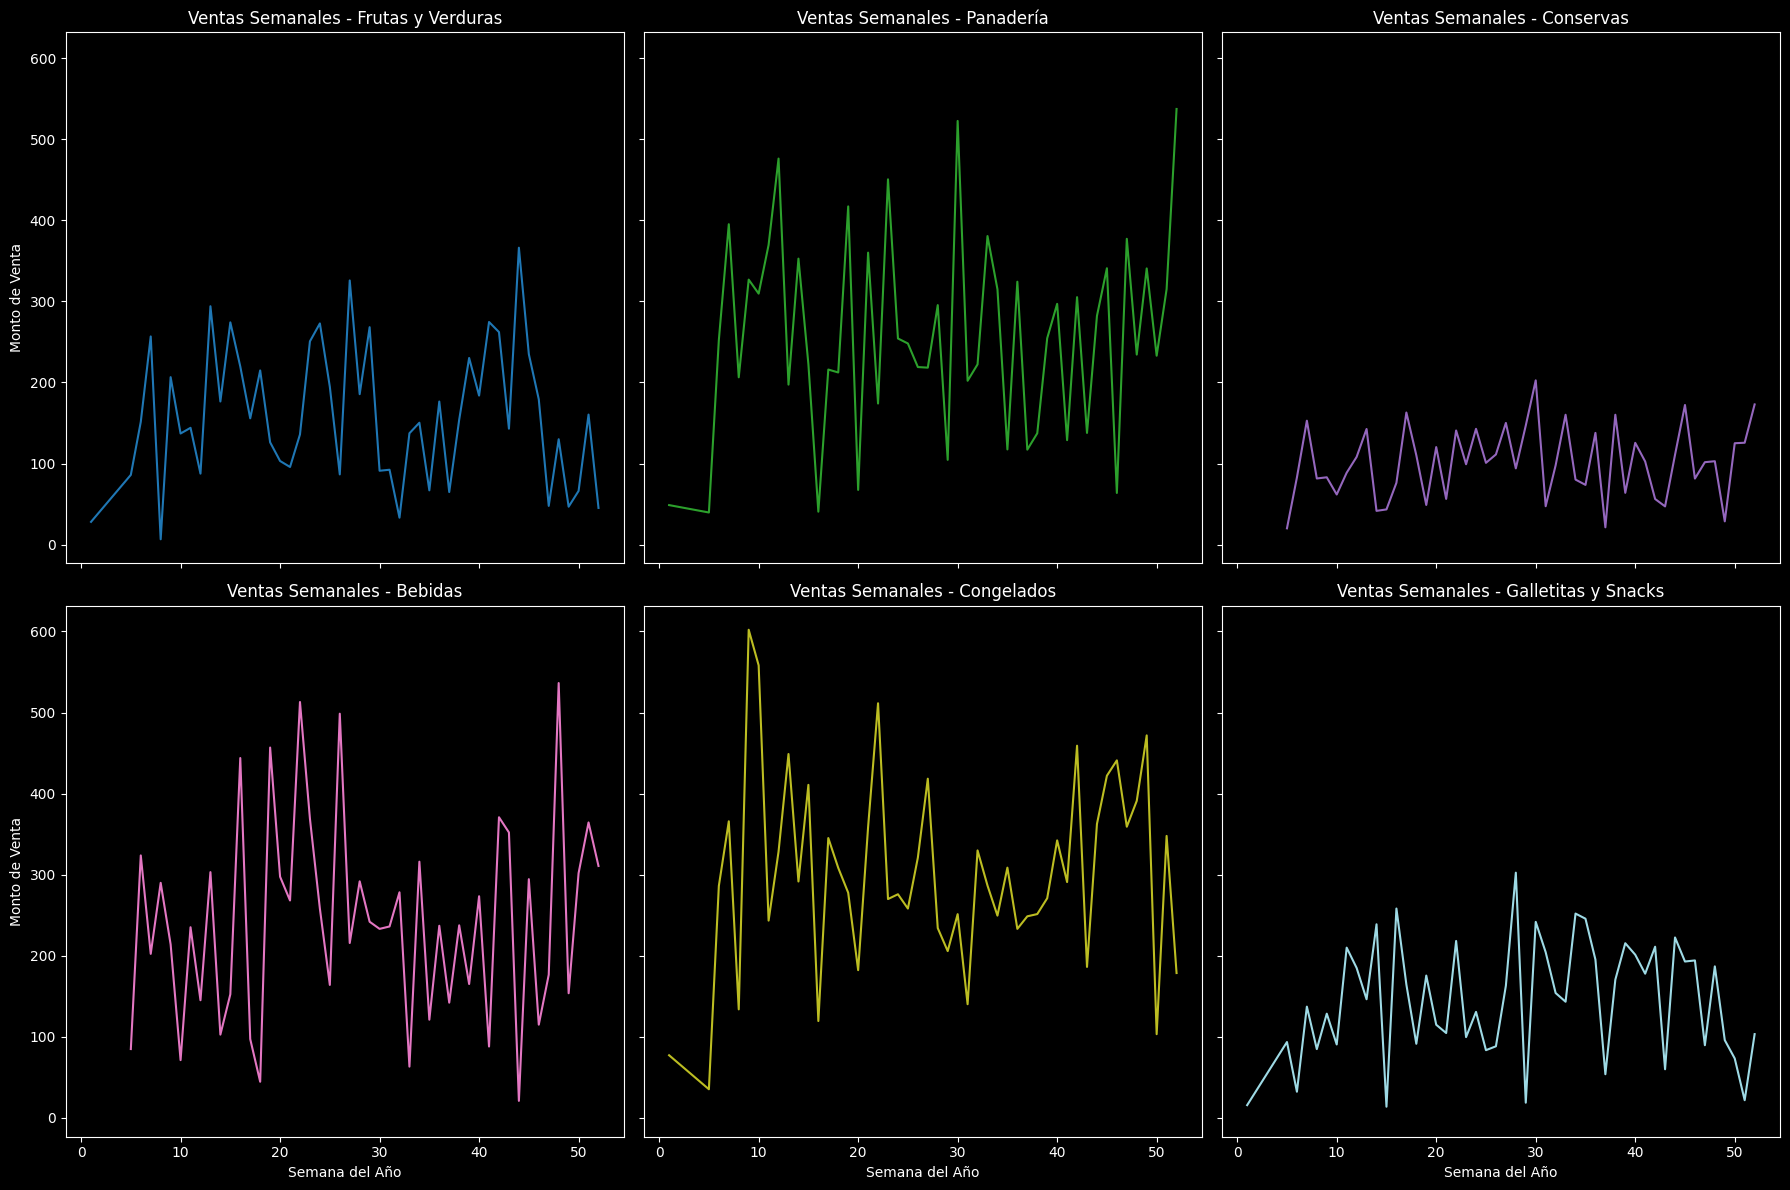

In [19]:
# Cuanto se vende en cada semana del año por categoría
df['Semana_Año'] = df['Fecha'].dt.isocalendar().week

num_categories = df['Categoria'].nunique()
cmap = plt.cm.get_cmap('tab20', num_categories)

fig, ax = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)
ax = ax.flatten()
for i, categoria in enumerate(df['Categoria'].unique()):
    ventas_semana = df[df['Categoria'] == categoria].groupby('Semana_Año')['Monto_Venta'].sum().reset_index()
    sns.lineplot(data=ventas_semana, x='Semana_Año', y='Monto_Venta', ax=ax[i], color=cmap(i))
    ax[i].set_title(f'Ventas Semanales - {categoria}')
    ax[i].set_xlabel('Semana del Año')
    ax[i].set_ylabel('Monto de Venta')
plt.tight_layout()
plt.show()

## Analisis de demanda a lo largo del tiempo

In [20]:
print('Las fechas con mayores ventas son:')
top_5_fechas = ventas_por_fecha.nlargest(5, 'Monto_Venta')
for index, row in top_5_fechas.iterrows():
    print(f"{row['Fecha'].date()}: {row['Monto_Venta']:.2f}")

print('\nLas fechas con menores ventas son:')
bottom_5_fechas = ventas_por_fecha.nsmallest(5, 'Monto_Venta')
for index, row in bottom_5_fechas.iterrows():
    print(f"{row['Fecha'].date()}: {row['Monto_Venta']:.2f}")

Las fechas con mayores ventas son:
2024-12-16: 555.92
2024-07-26: 524.58
2024-07-09: 489.72
2024-03-27: 416.28
2024-09-02: 415.37

Las fechas con menores ventas son:
2024-12-17: 10.01
2024-06-10: 13.36
2024-08-28: 13.56
2024-04-17: 21.17
2024-06-22: 23.15


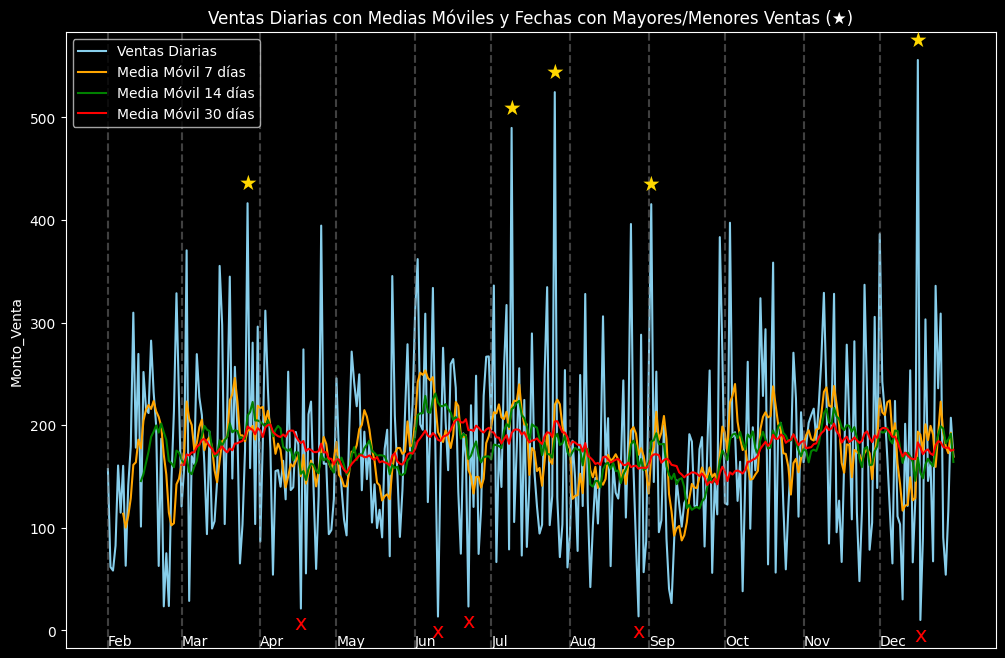

In [21]:
# Media movil de 7, 14 y 30 dias para ventas diarias
ventas_por_fecha['MA7'] = ventas_por_fecha['Monto_Venta'].rolling(window=7).mean()
ventas_por_fecha['MA14'] = ventas_por_fecha['Monto_Venta'].rolling(window=14).mean()
ventas_por_fecha['MA30'] = ventas_por_fecha['Monto_Venta'].rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='Monto_Venta', ax=ax, label='Ventas Diarias', color='skyblue')
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA7', ax=ax, label='Media Móvil 7 días', color='orange')
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA14', ax=ax, label='Media Móvil 14 días', color='green')
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA30', ax=ax, label='Media Móvil 30 días', color='red')

# 5 fechas con mayores ventas
for index, row in top_5_fechas.iterrows():
    ax.annotate('★', xy=(row['Fecha'], row['Monto_Venta']), xytext=(0,10), textcoords='offset points', ha='center', color='gold', fontsize=15)

# 5 fechas con menores ventas
for index, row in bottom_5_fechas.iterrows():
    ax.annotate('x', xy=(row['Fecha'], row['Monto_Venta']), xytext=(0,-15), textcoords='offset points', ha='center', color='red', fontsize=15)

# Lineas verticales por mes
for month_start in pd.date_range(start=ventas_por_fecha['Fecha'].min(), end=ventas_por_fecha['Fecha'].max(), freq='MS'):
    ax.axvline(x=month_start, color='gray', linestyle='--', alpha=0.5)
    ax.text(month_start, ax.get_ylim()[0], month_start.strftime('%b'), ha='left', va='bottom')
    ax.set_xlabel(None)
    ax.set_xticks([])

ax.legend()

# explin the stars
ax.set_title('Ventas Diarias con Medias Móviles y Fechas con Mayores/Menores Ventas (★)')

plt.show()

Picos en MA7: 13, Picos en MA14: 10
Distancia promedio entre picos en MA7: 23.83 días (rango: 9 - 51 días)
Distancia promedio entre picos en MA14: 34.11 días (rango: 21 - 54 días)


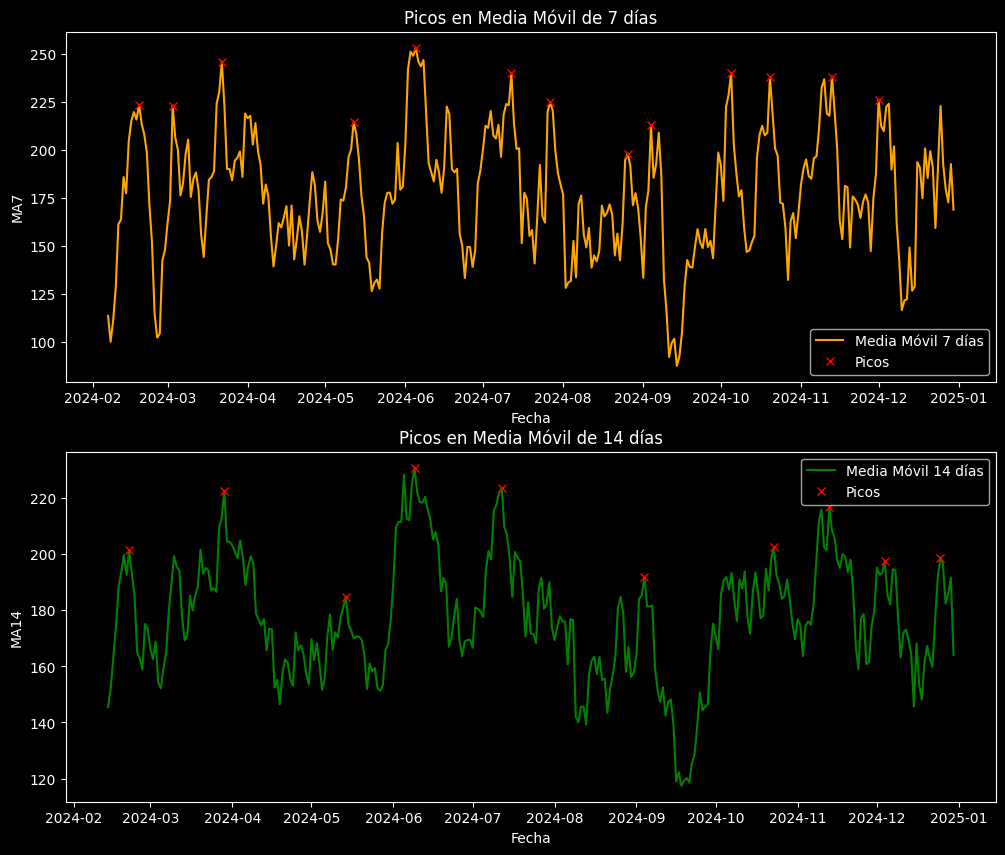

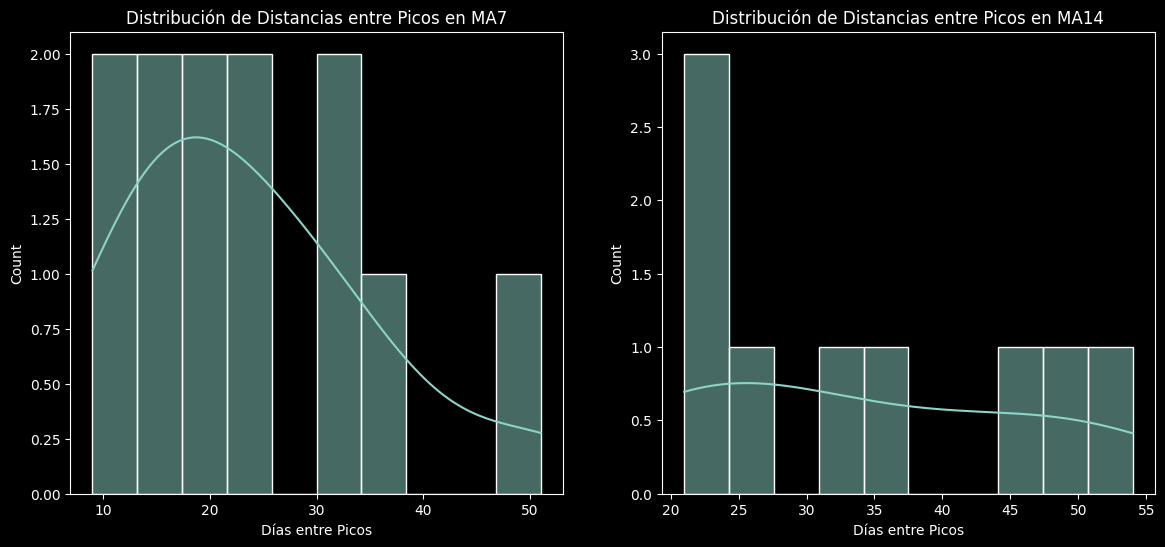

In [22]:
# Cuantificamos los picos de las medias moviles (cada cuanto se alcanza un maximo local)
peaks_7 = find_peaks(ventas_por_fecha['MA7'], prominence=60)[0]
peaks_14 = find_peaks(ventas_por_fecha['MA14'], prominence=30)[0]

print(f'Picos en MA7: {len(peaks_7)}, Picos en MA14: {len(peaks_14)}')

# Distancia promedio entre picos
distancias_7 = np.diff(peaks_7)
distancias_14 = np.diff(peaks_14)

print(f'Distancia promedio entre picos en MA7: {np.mean(distancias_7):.2f} días (rango: {np.min(distancias_7)} - {np.max(distancias_7)} días)')
print(f'Distancia promedio entre picos en MA14: {np.mean(distancias_14):.2f} días (rango: {np.min(distancias_14)} - {np.max(distancias_14)} días)')

# Plot picos en medias moviles
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA7', ax=ax[0], label='Media Móvil 7 días', color='orange')
ax[0].plot(ventas_por_fecha['Fecha'].iloc[peaks_7], ventas_por_fecha['MA7'].iloc[peaks_7], "x", color='red', label='Picos')
ax[0].set_title('Picos en Media Móvil de 7 días')
ax[0].legend()
sns.lineplot(data=ventas_por_fecha, x='Fecha', y='MA14', ax=ax[1], label='Media Móvil 14 días', color='green')
ax[1].plot(ventas_por_fecha['Fecha'].iloc[peaks_14], ventas_por_fecha['MA14'].iloc[peaks_14], "x", color='red', label='Picos')
ax[1].set_title('Picos en Media Móvil de 14 días')
ax[1].legend()
plt.show()

# Plot distribucion de distancias entre picos
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(distancias_7, bins=10, kde=True, ax=ax[0])
ax[0].set_title('Distribución de Distancias entre Picos en MA7')
ax[0].set_xlabel('Días entre Picos')
sns.histplot(distancias_14, bins=10, kde=True, ax=ax[1])
ax[1].set_title('Distribución de Distancias entre Picos en MA14')
ax[1].set_xlabel('Días entre Picos')
plt.show()

/tmp/ipykernel_54256/4288540196.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=estacionalidad, x='Mes', y='Porcentaje_Desviacion', palette='coolwarm')


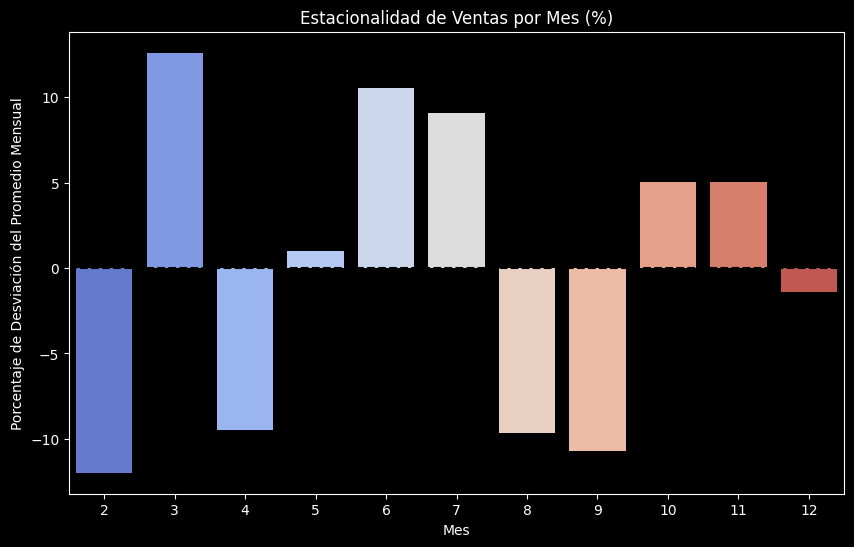

In [23]:
# Cuantificación de estacionalidad
df['Mes'] = df['Fecha'].dt.month
ventas_por_mes = df.groupby('Mes')['Monto_Venta'].sum().reset_index()
promedio_mensual = ventas_por_mes['Monto_Venta'].mean()
estacionalidad = ventas_por_mes.copy()
estacionalidad['Desviacion'] = estacionalidad['Monto_Venta'] - promedio_mensual
estacionalidad['Porcentaje_Desviacion'] = (estacionalidad['Desviacion'] / promedio_mensual) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=estacionalidad, x='Mes', y='Porcentaje_Desviacion', palette='coolwarm')
plt.title('Estacionalidad de Ventas por Mes (%)')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Desviación del Promedio Mensual')
plt.axhline(0, color='black', linestyle='--')
plt.show()

/tmp/ipykernel_54256/438839287.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metodos_pago_ventas, x='Metodo_Pago', y='Monto_Venta', ax=ax[0], palette='Set2')
/tmp/ipykernel_54256/438839287.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_54256/438839287.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
/tmp/ipykernel_54256/438839287.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation

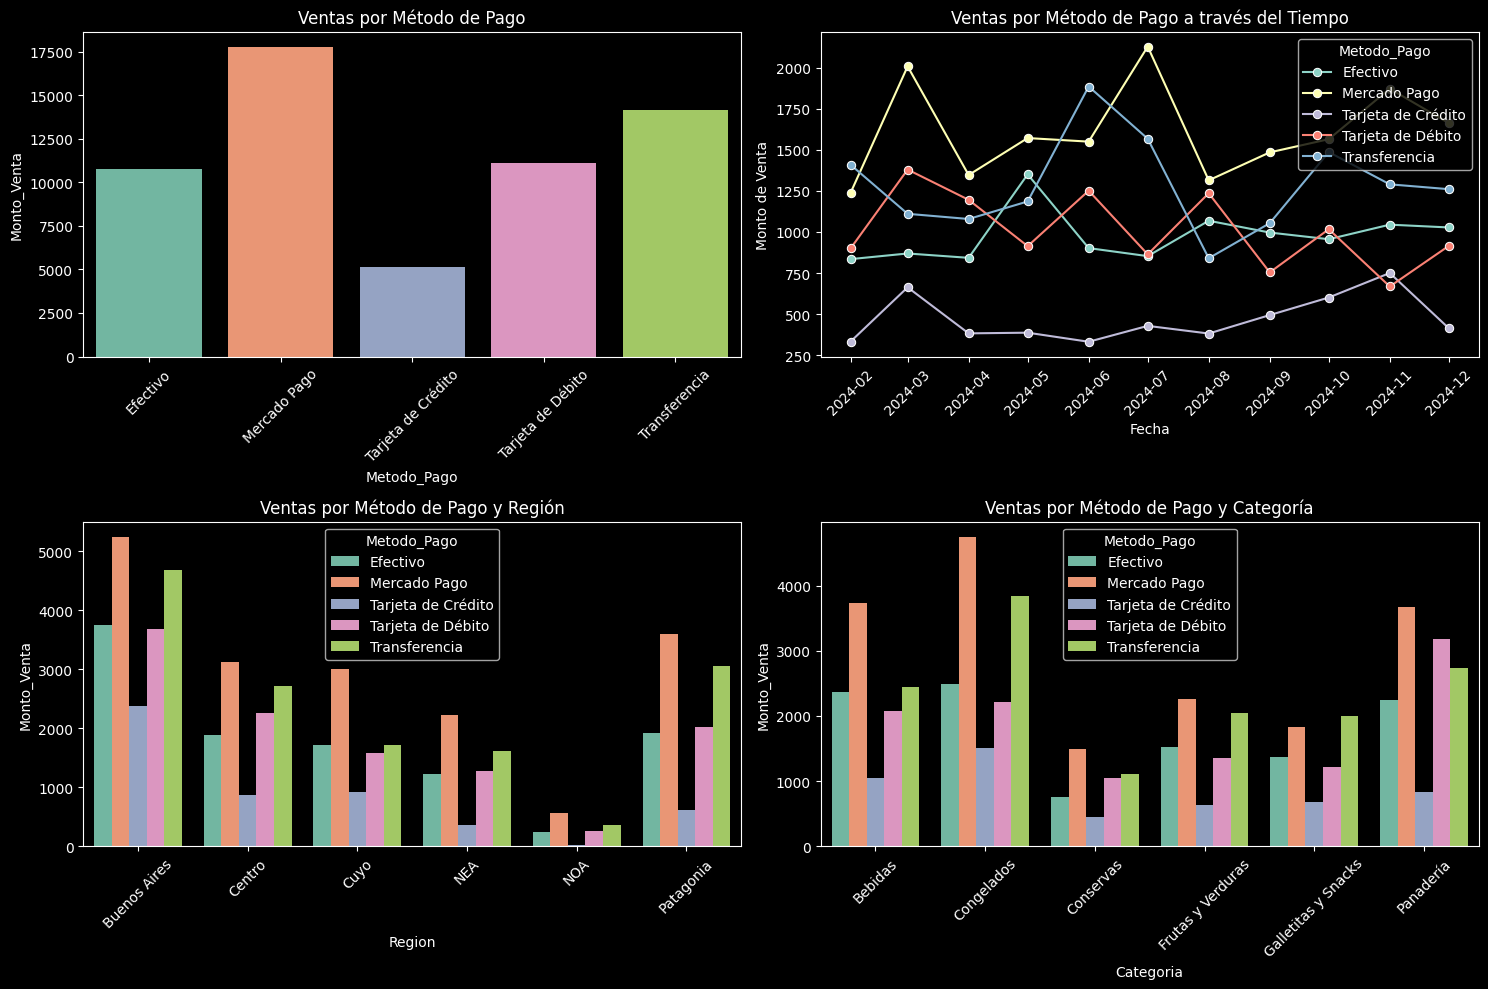

In [24]:
# Metodos de pago
metodos_pago_ventas = df.groupby('Metodo_Pago')['Monto_Venta'].sum().reset_index()

# Metodos de pago a través del tiempo
metodos_pago_tiempo = df.groupby([df['Fecha'].dt.to_period('M'), 'Metodo_Pago'])['Monto_Venta'].sum().reset_index()
metodos_pago_tiempo['Fecha'] = metodos_pago_tiempo['Fecha'].dt.to_timestamp()

# Metodos de pago por region
metodos_pago_region = df.groupby(['Region', 'Metodo_Pago'])['Monto_Venta'].sum().reset_index()

# Metodos de pago por categoría
metodos_pago_cantidad = df.groupby(['Categoria', 'Metodo_Pago'])['Monto_Venta'].sum().reset_index()

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()
sns.barplot(data=metodos_pago_ventas, x='Metodo_Pago', y='Monto_Venta', ax=ax[0], palette='Set2')
ax[0].set_title('Ventas por Método de Pago')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.lineplot(data=metodos_pago_tiempo, x='Fecha', y='Monto_Venta', hue='Metodo_Pago', ax=ax[1], marker='o')
ax[1].set_title('Ventas por Método de Pago a través del Tiempo')
ax[1].set_xlabel('Fecha')
ax[1].set_ylabel('Monto de Venta')
ax[1].tick_params(axis='x', rotation=45)

sns.barplot(data=metodos_pago_region, x='Region', y='Monto_Venta', hue='Metodo_Pago', ax=ax[2], palette='Set2')
ax[2].set_title('Ventas por Método de Pago y Región')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)

sns.barplot(data=metodos_pago_cantidad, x='Categoria', y='Monto_Venta', hue='Metodo_Pago', ax=ax[3], palette='Set2')
ax[3].set_title('Ventas por Método de Pago y Categoría')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)


plt.tight_layout()
plt.show()



Podemos observar que el patron de ventas es estacional (es decir, no ha tendido a crecer o decrecer de forma consistente a lo largo del tiempo), pero con picos muy pronunciados. Estos picos no parecen depender del día de la semana.

Podemos observar tambien que hay ciertos meses con ventas  más altas que otros, esto puede indicar patrones en la demanda, aunque con datos de solamente un año es difícil de determinar si esto proviene de aleatoriedad o si es un patrón real.

Además, las medias moviles demuestran un patrón cíclico, con picos y valles que se repiten aproximadamente cada 0.5-2 meses. Esto sugiere que las ventas pueden estar influenciadas por factores estacionales o eventos periódicos.

El metodo de pago principal es Mercado Pago. Esto se mantiene en todas las regiones y categorías de productos (menos galletitas y snaks, donde esta muy cerca del primer lugar). Notamos que en verano hay un aument en el uso de transferencias.

El analisis de elasticidad no tiene sentido en este caso, pues los precios unitarios son fijos y no varian a lo largo del tiempo.

Hacemos enfasis en que tener datos de solamente un año limita el analisis de patrones estacionales y tendencias a largo plazo. Seria ideal contar con datos de varios años para obtener conclusiones más robustas.